In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
batch_size = 128

fn_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Pad(2),
])

dataset = datasets.FashionMNIST(
    "../data",
    train=True,
    download=True,
    transform=fn_transform
)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

label_to_name_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}
name_to_label_map = {
    name: label for label, name in label_to_name_map.items()
}

num_classes = len(label_to_name_map)

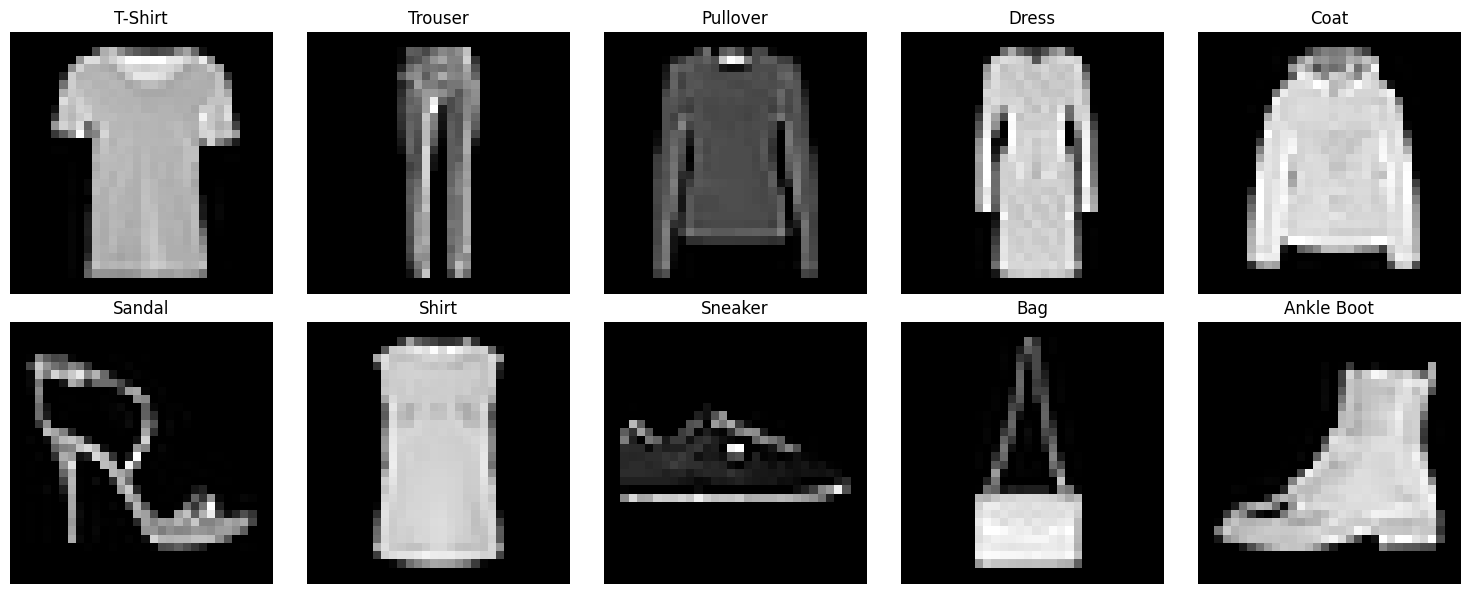

In [3]:
from scripts.visualization import visualize_fashion_mnist_classes

tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
visualize_fashion_mnist_classes(tmp_loader, label_to_name_map)

In [4]:
from scripts.nn_blocks import device

print(f"Device utilisé actuellement: {device}")

Device utilisé actuellement: mps


In [5]:
import torch
import torch.nn as nn
from scripts.u_net import UNet

unet_base_channel = 128
emb = nn.Embedding(num_classes, unet_base_channel*4).to(device)
unet = UNet(
    source_channel=1,
    unet_base_channel=unet_base_channel,
    num_norm_groups=32,
).to(device)

In [6]:
batch, labels = next(iter(tmp_loader))
t = torch.randint(0, 1000, (batch.size(0),)).to(device)
out = unet(batch.to(device), t, emb(labels.to(device)))
t.shape, batch.shape, labels.shape, out.shape

(torch.Size([128]),
 torch.Size([128, 1, 32, 32]),
 torch.Size([128]),
 torch.Size([128, 1, 32, 32]))

In [7]:
import random

p_uncond = 0.2

opt = torch.optim.Adam(list(emb.parameters()) + list(unet.parameters()), lr=2e-4, eps=1e-08)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=1.0/5000,
    end_factor=1.0,
    total_iters=5000)

T = 1000
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float32).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_bars_t = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars_t = torch.sqrt(1.0 - alpha_bars)

num_epochs = 200

In [8]:
import torch.nn.functional as F
from tqdm import tqdm

for epoch_idx in range(num_epochs):
    epoch_loss = []

    loop = tqdm(loader, leave=True)
    loop.set_description(f"Epoch {epoch_idx+1}/{num_epochs}")

    for batch_idx, (data, y) in enumerate(loader):
        unet.train()
        opt.zero_grad()

        x_0 = data.to(device)
        y_ = y.to(device)

        b = x_0.size(dim=0)
        t = torch.randint(T, (b,)).to(device)

        eps = torch.randn_like(x_0).to(device)

        x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps
        y_emb = emb(y_)

        rnd = torch.rand(b).to(device)
        mul = torch.where(rnd < p_uncond, 0.0, 1.0)
        y_emb = y_emb * mul[:,None]

        model_out = unet(x_t, t, y_emb)
        loss = F.mse_loss(model_out, eps, reduction="mean")
        loss.backward()
        opt.step()
        scheduler.step()

        epoch_loss.append(loss.item())
        # print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")
        loop.set_postfix(loss=loss.item())

    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    # print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss)) # type: ignore
    print(f"Epoch {epoch_idx+1} completed. Avg Loss: {epoch_average_loss:.4f}")
    
    torch.save(unet.state_dict(), f"../checkpoints/guided_unet_{epoch_idx}.pt")
    torch.save(emb.state_dict(), f"../checkpoints/guided_embedding_{epoch_idx}.pt")

print("Done")

Epoch 1/200:   0%|          | 0/469 [03:00<?, ?it/s, loss=0.666]

KeyboardInterrupt: 